In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

from collections import OrderedDict

import sys
sys.path.append("..")
import utilities, ontology

# Load brain and text data

In [2]:
act_bin = utilities.load_coordinates().astype(float)
print("Document N={}, Structure N={}".format(act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


In [3]:
version = 190325
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)
print("Document N={}, Term N={}".format(dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


In [4]:
frameworks = ["data-driven", "data-driven", "rdoc", "dsm"]
list_suffixes = ["", "", "_opsim", "_opsim"]
circuit_suffixes = ["_terms", "_lr", "", ""]
lists, circuits = {}, {}
for fw, list_suffix, circuit_suffix in zip(frameworks, list_suffixes, circuit_suffixes):
    lists[fw+circuit_suffix], circuits[fw+circuit_suffix] = utilities.load_framework(fw, suffix=list_suffix, clf=circuit_suffix)

In [5]:
frameworks = [fw+circuit_suffix for fw, circuit_suffix in zip(frameworks, circuit_suffixes)]

In [6]:
scores = {fw: utilities.score_lists(lists[fw], dtm_bin, label_var="DOMAIN") for fw in frameworks}

In [7]:
words = []
for fw in frameworks:
    words += list(lists[fw]["TOKEN"])
words = sorted(list(set(words)))
structures = list(act_bin.columns)
print("Term N={}, Structure N={}".format(len(words), len(structures)))

Term N=349, Structure N=118


In [8]:
domains = {fw: list(OrderedDict.fromkeys(lists[fw]["DOMAIN"])) for fw in frameworks}

In [9]:
pmids = act_bin.index.intersection(scores["rdoc"].index).intersection(scores["dsm"].index)
len(pmids)

18155

In [10]:
for fw in frameworks:
    scores[fw] = scores[fw].loc[pmids]

In [11]:
dtm_bin = dtm_bin.loc[pmids, words]
act_bin = act_bin.loc[pmids, structures]

# Load frameworks

In [12]:
fw2names = {
    "data-driven_lr": ["Memory", "Reward", "Cognition", "Vision", "Manipulation", "Language"],
    "data-driven_terms": ["Memory", "Emotion", "Inference", "Cognition", "Vision", "Language"],
    "rdoc": ["Negative", "Positive", "Arousal & Reg.", "Social", "Cognitive", "Sensorimotor"],
    "dsm": ["Depressive", "Anxiety", "Trauma & Stressor", "Obsess.-Compuls.", 
            "Disruptive", "Substance", "Developmental", "Psychotic", "Bipolar"]
}

In [13]:
systems = {}
for fw in frameworks:
    fw_df = pd.DataFrame(0.0, index=words+structures, columns=domains[fw])
    for dom in domains[fw]:
        for word in lists[fw].loc[lists[fw]["DOMAIN"] == dom, "TOKEN"]:
            fw_df.loc[word, dom] = 1.0
        for struct in structures:
            fw_df.loc[struct, dom] = circuits[fw].loc[struct, dom]
    fw_df[fw_df > 0.0] = 1.0
    fw_df.columns = fw2names[fw]
    systems[fw] = fw_df

In [14]:
domains = fw2names

# Similarity of RDoC and data-driven terms

## Observed values

In [15]:
from scipy.spatial.distance import dice, cdist
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style

font_prop = font_manager.FontProperties(fname=style.font, size=20)
rcParams["axes.linewidth"] = 1.5

%matplotlib inline

In [16]:
def compute_sim_obs(fw, fw_base="data-driven_terms"):
    sims = pd.DataFrame(index=domains[fw_base], columns=domains[fw])
    for k in domains[fw_base]:
        for r in domains[fw]:
            sims.loc[k,r] = 1.0 - dice(systems[fw_base][k], systems[fw][r])
    return sims

In [17]:
sims = compute_sim_obs("rdoc")
sims

,Negative,Positive,Arousal & Reg.,Social,Cognitive,Sensorimotor
Memory,0.293103,0.036036,0.230088,0.319328,0.101695,0.0172414
Emotion,0.677165,0.540984,0.419355,0.276923,0.0155039,0
Inference,0.0754717,0.019802,0.0776699,0.256881,0.185185,0.150943
Cognition,0.178862,0.20339,0.0333333,0,0.576,0.422764
Vision,0.0152672,0,0.046875,0.134328,0.406015,0.519084
Language,0.135593,0.0176991,0.156522,0.297521,0.166667,0.169492


In [18]:
def plot_sims(sims, outfile, figsize=(2.8,2.8), plot_cbar=False):
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0,0,1,1])
    font_prop = font_manager.FontProperties(fname=style.font, size=20)

    im = plt.imshow(sims.values.astype(float), cmap=plt.cm.gray)

    plt.xticks(range(0,sims.shape[1]), fontproperties=font_prop, rotation=60, ha="right")
    plt.yticks(range(0,sims.shape[0]), fontproperties=font_prop)
    ax.set_xticklabels(sims.columns)
    ax.set_yticklabels(sims.index)
    ax.xaxis.set_tick_params(width=1.5, length=7, top=False)
    ax.yaxis.set_tick_params(width=1.5, length=7)
    plt.clim(0, 1)

    if plot_cbar:
        cbar = plt.colorbar()
        cbar.solids.set_edgecolor("face")
    
    plt.savefig(outfile, dpi=250, bbox_inches="tight")
    plt.show()
    plt.close()

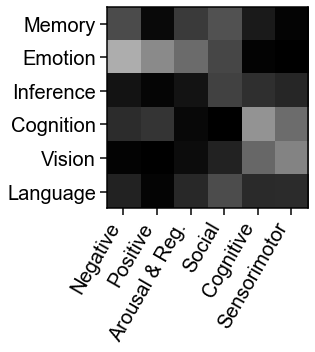

In [19]:
plot_sims(sims, "figures/sim_dd-terms_rdoc.png", plot_cbar=False)

## Null distribution

In [20]:
def compute_sim_null(fw, n_iter=10000, fw_base="data-driven_terms"):
    sims_null = np.empty((len(domains[fw_base]), len(domains[fw]), n_iter))
    for n in range(n_iter):
        null = np.random.choice(words+structures, 
                                size=len(words+structures), replace=False)
        sims_null[:,:,n] = 1.0 - cdist(systems[fw_base].loc[null].values.T, 
                                       systems[fw].values.T, metric="dice")
        if n % (float(n_iter) / 10.0) == 0:
            print("Iteration {}".format(n))
    return sims_null

In [21]:
sims_null = compute_sim_null("rdoc")

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


## False discovery rate

In [22]:
from statsmodels.stats.multitest import multipletests

In [23]:
def compute_sim_fdr(fw, sims, sims_null, fw_base="data-driven_terms"):
    n_iter = sims_null.shape[2]
    pvals = pd.DataFrame(index=domains[fw_base], columns=domains[fw])
    for i, k in enumerate(domains[fw_base]):
        for j, r in enumerate(domains[fw]):
            pvals.loc[k,r] = np.sum(sims_null[i,j,:] > sims.loc[k,r]) / float(n_iter)
    fdrs = multipletests(pvals.values.ravel(), method="fdr_bh")[1]
    fdrs = np.reshape(fdrs, pvals.shape)
    fdrs = pd.DataFrame(fdrs, index=domains[fw_base], columns=domains[fw])
    return fdrs

In [24]:
fdrs = compute_sim_fdr("rdoc", sims, sims_null)
fdrs

,Negative,Positive,Arousal & Reg.,Social,Cognitive,Sensorimotor
Memory,0,1,0.0121846,0,1,1
Emotion,0,0,0,0.0006,1,1
Inference,1,1,1,0.0006,0.06768,0.228126
Cognition,0.204525,0.054,1,1,0,0
Vision,1,1,1,0.792655,0,0
Language,0.542229,1,0.25434,0,0.228126,0.228126


In [25]:
def compute_sim_star(fw, fdrs, fw_base="data-driven_terms"):
    stars = pd.DataFrame("", index=domains[fw_base], columns=domains[fw])
    for k in domains[fw_base]:
        for r in domains[fw]:
            fdr = fdrs.loc[k,r]
            if fdr < 0.05:
                stars.loc[k,r] = "*"
            if fdr < 0.01:
                stars.loc[k,r] = "**"
            if fdr < 0.001:
                stars.loc[k,r] = "***"
    return stars

In [26]:
stars = compute_sim_star("rdoc", fdrs)
stars

,Negative,Positive,Arousal & Reg.,Social,Cognitive,Sensorimotor
Memory,***,,*,***,,
Emotion,***,***,***,***,,
Inference,,,,***,,
Cognition,,,,,***,***
Vision,,,,,***,***
Language,,,,***,,


## Weights for figure

In [27]:
sims[fdrs < 0.05] * 50

,Negative,Positive,Arousal & Reg.,Social,Cognitive,Sensorimotor
Memory,14.6552,NaN,11.5044,15.9664,NaN,NaN
Emotion,33.8583,27.0492,20.9677,13.8462,NaN,NaN
Inference,NaN,NaN,NaN,12.844,NaN,NaN
Cognition,NaN,NaN,NaN,NaN,28.8,21.1382
Vision,NaN,NaN,NaN,NaN,20.3008,25.9542
Language,NaN,NaN,NaN,14.876,NaN,NaN


# Similarity of RDoC and data-driven LR

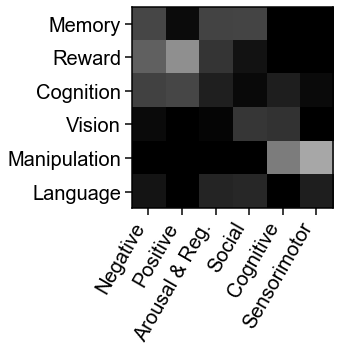

In [28]:
sims = compute_sim_obs("rdoc", fw_base="data-driven_lr")
plot_sims(sims, "figures/sim_dd-lr_rdoc.png")

# Similarity of DSM and data-driven terms

## Observed values

In [29]:
sims = compute_sim_obs("dsm")
sims

,Depressive,Anxiety,Trauma & Stressor,Obsess.-Compuls.,Disruptive,Substance,Developmental,Psychotic,Bipolar
Memory,0.0769231,0.177215,0.219178,0,0,0,0.0747664,0,0.0833333
Emotion,0.0898876,0.244444,0.190476,0.146341,0.188235,0.0722892,0,0,0.144578
Inference,0,0.0289855,0,0,0,0,0.309278,0.181818,0
Cognition,0.0235294,0.0465116,0,0.102564,0.0740741,0.0506329,0.210526,0.168675,0.0759494
Vision,0,0,0,0.0232558,0,0.0229885,0.409836,0.10989,0
Language,0,0.0246914,0,0,0,0,0.330275,0.153846,0


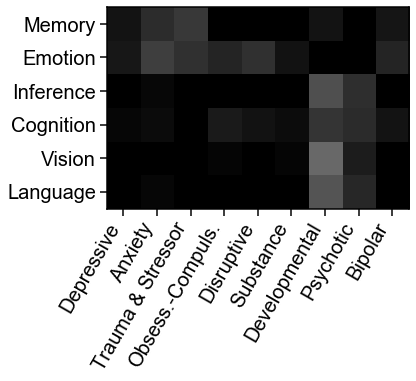

In [30]:
plot_sims(sims, "figures/sim_dd-terms_dsm.png", figsize=(5,2.8))

## Null distribution

In [31]:
sims_null = compute_sim_null("dsm")

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


## False discovery rate

In [32]:
fdrs = compute_sim_fdr("dsm", sims, sims_null)
fdrs

,Depressive,Anxiety,Trauma & Stressor,Obsess.-Compuls.,Disruptive,Substance,Developmental,Psychotic,Bipolar
Memory,0.559145,0.0063,0,0.990849,0.990849,0.990849,0.990849,0.990849,0.251894
Emotion,0.424543,0,0.0009,0.0054,0.00154286,0.383684,0.9998,0.990849,0.0063
Inference,0.990849,0.990849,0.990849,0.990849,0.990849,0.990849,0,0.0054,0.990849
Cognition,0.990849,0.990849,0.990849,0.08352,0.424543,0.714913,0.0378,0.0063,0.345
Vision,0.990849,0.990849,0.990849,0.990849,0.990849,0.990849,0,0.156938,0.990849
Language,0.990849,0.990849,0.990849,0.990849,0.990849,0.990849,0,0.0166154,0.990849


In [33]:
stars = compute_sim_star("dsm", fdrs)
stars

,Depressive,Anxiety,Trauma & Stressor,Obsess.-Compuls.,Disruptive,Substance,Developmental,Psychotic,Bipolar
Memory,,**,***,,,,,,
Emotion,,***,***,**,**,,,,**
Inference,,,,,,,***,**,
Cognition,,,,,,,*,**,
Vision,,,,,,,***,,
Language,,,,,,,***,*,


## Weights for figure

In [34]:
sims[fdrs < 0.05] * 50

,Depressive,Anxiety,Trauma & Stressor,Obsess.-Compuls.,Disruptive,Substance,Developmental,Psychotic,Bipolar
Memory,NaN,8.86076,10.9589,NaN,NaN,NaN,NaN,NaN,NaN
Emotion,NaN,12.2222,9.52381,7.31707,9.41176,NaN,NaN,NaN,7.22892
Inference,NaN,NaN,NaN,NaN,NaN,NaN,15.4639,9.09091,NaN
Cognition,NaN,NaN,NaN,NaN,NaN,NaN,10.5263,8.43373,NaN
Vision,NaN,NaN,NaN,NaN,NaN,NaN,20.4918,NaN,NaN
Language,NaN,NaN,NaN,NaN,NaN,NaN,16.5138,7.69231,NaN


# Similarity of DSM and data-driven LR

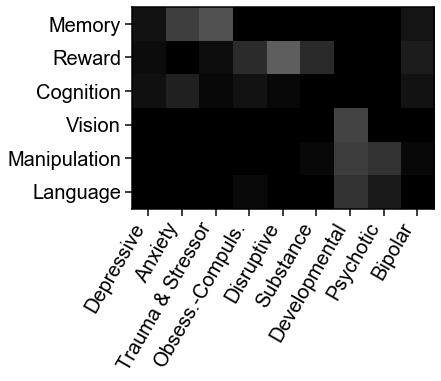

In [35]:
sims = compute_sim_obs("dsm", fw_base="data-driven_lr")
plot_sims(sims, "figures/sim_dd-lr_dsm.png", figsize=(5,2.8))

# Similarity of data-driven system versions

## Observed values

In [36]:
sims = compute_sim_obs("data-driven_lr")
sims

,Memory,Reward,Cognition,Vision,Manipulation,Language
Memory,0.553191,0,0.1,0.42,0.039604,0.019802
Emotion,0.285714,0.417582,0.378378,0,0,0.0357143
Inference,0.047619,0,0.2,0.177778,0.10989,0.21978
Cognition,0,0.045977,0.373832,0.0186916,0.5,0
Vision,0,0,0,0.365217,0.517241,0.137931
Language,0.0416667,0,0.0784314,0.235294,0.0776699,0.543689


## Null distribution

In [37]:
sims_null = compute_sim_null("data-driven_lr")

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


## False discovery rate

In [38]:
fdrs = compute_sim_fdr("data-driven_lr", sims, sims_null)
fdrs

,Memory,Reward,Cognition,Vision,Manipulation,Language
Memory,0,0.9995,0.905929,0,0.9995,0.9995
Emotion,0,0,0,0.9995,0.9995,0.9995
Inference,0.9995,0.9995,0.0138462,0.0493714,0.637875,0.0057
Cognition,0.9995,0.9995,0,0.9995,0,0.9995
Vision,0.9995,0.9995,0.9995,0,0,0.48696
Language,0.9995,0.9995,0.9995,0.00490909,0.9995,0


In [39]:
stars = compute_sim_star("data-driven_lr", fdrs)
stars

,Memory,Reward,Cognition,Vision,Manipulation,Language
Memory,***,,,***,,
Emotion,***,***,***,,,
Inference,,,*,*,,**
Cognition,,,***,,***,
Vision,,,,***,***,
Language,,,,**,,***


## Weights for figure

In [40]:
sims[fdrs < 0.05] * 50

,Memory,Reward,Cognition,Vision,Manipulation,Language
Memory,27.6596,NaN,NaN,21,NaN,NaN
Emotion,14.2857,20.8791,18.9189,NaN,NaN,NaN
Inference,NaN,NaN,10,8.88889,NaN,10.989
Cognition,NaN,NaN,18.6916,NaN,25,NaN
Vision,NaN,NaN,NaN,18.2609,25.8621,NaN
Language,NaN,NaN,NaN,11.7647,NaN,27.1845


# Compare RDoC similarity between data-driven versions

In [41]:
sims_terms = compute_sim_obs("rdoc", fw_base="data-driven_terms")
sims_lr = compute_sim_obs("rdoc", fw_base="data-driven_lr")
sims = {"lr": sims_lr, "terms": sims_terms}

In [42]:
# null_terms = compute_sim_null("rdoc", fw_base="data-driven_terms")
# null_lr = compute_sim_null("rdoc", fw_base="data-driven_lr")

In [43]:
def compute_sim_boot(fw, n_iter=10000, fw_base="data-driven_terms"):
    sims_boot = np.empty((len(domains[fw_base]), len(domains[fw]), n_iter))
    for n in range(n_iter):
        boot = np.random.choice(words+structures, 
                                size=len(words+structures), replace=True)
        sims_boot[:,:,n] = 1.0 - cdist(systems[fw_base].loc[boot].values.T, 
                                       systems[fw].loc[boot].values.T, metric="dice")
        if n % (float(n_iter) / 10.0) == 0:
            print("Iteration {}".format(n))
    return sims_boot

In [44]:
boot_terms = compute_sim_boot("rdoc", fw_base="data-driven_terms")
boot_lr = compute_sim_boot("rdoc", fw_base="data-driven_lr")

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [45]:
mean_boot_terms = np.mean(np.mean(boot_terms, axis=0), axis=0)
mean_boot_lr = np.mean(np.mean(boot_lr, axis=0), axis=0)
boot = {"lr": list(mean_boot_lr), "terms": list(mean_boot_terms)}

In [46]:
n_iter = boot_terms.shape[2]
pval_dif = np.sum(np.less(mean_boot_terms - mean_boot_lr, 0.0)) / n_iter
pval_dif

0.0

In [47]:
def plot_comparison(boot, sims, filename, path="", n_iter=1000, print_fig=True, 
                    font=style.font, dx=0.38, ylim=[0,0.25], yticks=[0,0.0625,0.125,0.1875,0.25]):

    font_lg = font_manager.FontProperties(fname=font, size=20)
    rcParams["axes.linewidth"] = 1.5

    fig = plt.figure(figsize=(1.25, 4.25))
    ax = fig.add_axes([0,0,1,1])

    i = 0
    labels = []
    for fw, dist in boot.items():
        labels.append(fw)
        dist_avg = np.mean(dist, axis=0)
        macro_avg = np.mean(np.mean(sims[fw], axis=0), axis=0)
        plt.plot([i-dx, i+dx], [macro_avg, macro_avg], 
                 c="gray", alpha=1, lw=2, zorder=-1)
        v = ax.violinplot(sorted(dist), positions=[i], 
                          showmeans=False, showmedians=False, widths=0.85)
        for pc in v["bodies"]:
            pc.set_facecolor("gray")
            pc.set_edgecolor("gray")
            pc.set_linewidth(2)
            pc.set_alpha(0.5)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")
        i += 1

    ax.set_xticks(range(len(boot.keys())))
    ax.set_xticklabels([], rotation=60, ha="right")
    plt.xticks(fontproperties=font_lg)
    plt.yticks(yticks, fontproperties=font_lg)
    plt.xlim([-0.75, len(boot.keys())-0.25])
    plt.ylim(ylim)
    
    for side in ["right", "top"]:
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(width=1.5, length=7)
    ax.yaxis.set_tick_params(width=1.5, length=7)
    
    plt.savefig("{}figures/{}".format(path, filename), dpi=250, bbox_inches="tight")

    if print_fig:
        plt.show()
    plt.close()

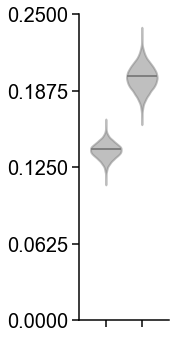

In [48]:
plot_comparison(boot, sims, "sim_dd_rdoc.png")

# Compare DSM similarity between data-driven versions

In [49]:
sims_terms = compute_sim_obs("dsm", fw_base="data-driven_terms")
sims_lr = compute_sim_obs("dsm", fw_base="data-driven_lr")
sims = {"lr": sims_lr, "terms": sims_terms}

In [50]:
# null_terms = compute_sim_null("dsm", fw_base="data-driven_terms")
# null_lr = compute_sim_null("dsm", fw_base="data-driven_lr")

In [51]:
boot_terms = compute_sim_boot("dsm", fw_base="data-driven_terms")
boot_lr = compute_sim_boot("dsm", fw_base="data-driven_lr")

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [52]:
mean_boot_terms = np.mean(np.mean(boot_terms, axis=0), axis=0)
mean_boot_lr = np.mean(np.mean(boot_lr, axis=0), axis=0)
boot = {"lr": list(mean_boot_lr), "terms": list(mean_boot_terms)}

In [53]:
np.mean(np.mean(sims["lr"], axis=0), axis=0)

0.058051587819821684

In [54]:
np.mean(np.mean(sims["terms"], axis=0), axis=0)

0.07509252454800658

In [55]:
n_iter = boot_terms.shape[2]
pval_dif = np.sum(np.less(mean_boot_terms - mean_boot_lr, 0.0)) / n_iter
pval_dif

0.0415

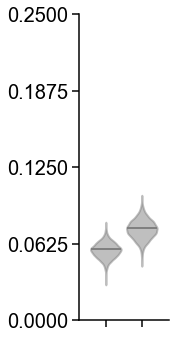

In [56]:
plot_comparison(boot, sims, "sim_dd_dsm.png")